# <a id='toc1_'></a>[LendingClub Machine Learning](#toc0_)

I've been asked to work on this project, approaching it from the following angle:


Imagine that you are a data scientist who was just hired by the LendingClub.
They want to automate their lending decisions fully, and they hired you to lead this project.
Your team consists of a product manager to help you understand the business domain and a software engineer who will help you integrate your solution into their product.
During the initial investigations, you've found that there was a similar initiative in the past, and luckily for you, they have left a somewhat clean dataset of LendingClub's loan data.
The dataset is located in a public bucket here: <https://storage.googleapis.com/335-lending-club/lending-club.zip> (although you were wondering if having your client data in a public bucket is such a good idea).
In the first meeting with your team, you all have decided to use this dataset because it will allow you to skip months of work of building a dataset from scratch.
In addition, you have decided to tackle this problem iteratively so that you can get test your hypothesis that you can automate these decisions and get actual feedback from the users as soon as possible.
For that, you have proposed a three-step plan on how to approach this problem.
The first step of your plan is to create a machine learning model to classify loans into accepted/rejected so that you can start learning if you have enough data to solve this simple problem adequately.
The second step is to predict the grade for the loan, and the third step is to predict the subgrade and the interest rate.
Your team likes the plan, especially because after every step, you'll have a fully-working deployed model that your company can use.
Excitedly you get to work!

&nbsp;

The project will be divided into 3 parts:

- **Part 1:** Loan Approval Classification (this part)

- **Part 2:** Loan Grade Classification

- **Part 3:** Loan Sub Grade Classification And Interest Rate Regression


**Table of contents**<a id='toc0_'></a>    
- [LendingClub Machine Learning](#toc1_)    
  - [Setup](#toc1_1_)    
    - [Installation and Imports](#toc1_1_1_)    
    - [Initial Setup](#toc1_1_2_)    
  - [Data Loading and Exploration](#toc1_2_)    
    - [Data Loading](#toc1_2_1_)    
    - [First Exploration](#toc1_2_2_)    
  - [Matching Columns](#toc1_3_)    
      - [Amount Requested](#toc1_3_1_1_)    
      - [Risk Score](#toc1_3_1_2_)    
      - [Debt to Income Ratio](#toc1_3_1_3_)    
      - [Employment Length](#toc1_3_1_4_)    
      - [Policy Code](#toc1_3_1_5_)    
      - [Conclusion](#toc1_3_1_6_)    
  - [Data Cleaning](#toc1_4_)    
    - [Amount](#toc1_4_1_)    
    - [Risk Score](#toc1_4_2_)    
    - [Debt To Income Ratio](#toc1_4_3_)    
    - [Employment Length](#toc1_4_4_)    
      - [Saving](#toc1_4_4_1_)    
  - [EDA: Exploratory Data Analysis](#toc1_5_)    
      - [Amount](#toc1_5_1_1_)    
      - [Risk Score](#toc1_5_1_2_)    
      - [Debt To Income Ratio](#toc1_5_1_3_)    
      - [Employment Length](#toc1_5_1_4_)    
      - [Approved](#toc1_5_1_5_)    
    - [Dataset Balancing](#toc1_5_2_)    
    - [Correlations](#toc1_5_3_)    
  - [Statistical Analysis](#toc1_6_)    
    - [Hypothesis: Amount vs Debt To Income Ratio](#toc1_6_1_)    
  - [Machine Learning](#toc1_7_)    
    - [Data Loading](#toc1_7_1_)    
      - [Train - Test Split](#toc1_7_1_1_)    
    - [Model Training and Evaluation](#toc1_7_2_)    
      - [Logistic Regression](#toc1_7_2_1_)    
    - [XGBoost](#toc1_7_3_)    
  - [Summary](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


---

## <a id='toc1_1_'></a>[Setup](#toc0_)

This section contains the installation of required packages, importing them into the project and initial setup.

### <a id='toc1_1_1_'></a>[Installation and Imports](#toc0_)

In [1]:
%pip install --upgrade pip
%pip install -q -r src/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import dask.dataframe as dd
import src.lib.functions as f
import pprint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, recall_score, f1_score
import optuna
import joblib
import os
import numpy as np

### <a id='toc1_1_2_'></a>[Initial Setup](#toc0_)

In [3]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 80
logger = f.get_logger()
pp = pprint.PrettyPrinter(indent=4, width=120)
pd.set_option('display.max_columns', None)
palette_inverted =[f.COLOR_CONTRAST, f.COLOR_MAIN]

&nbsp;

&nbsp;

---

## <a id='toc1_2_'></a>[Data Loading and Exploration](#toc0_)

This section describes the loading of the data and a first exploration.

&nbsp;

### <a id='toc1_2_1_'></a>[Data Loading](#toc0_)

Now that everything is installed and imported, let's get started by loading the data into a DataFrame. 

Note: Because the datasets are quite large files and automatic inference of data type is resource intensive, I'm importing all values as strings. Setting the correct data types can then be done after exploration.

In [4]:
run_data_cells = True
if run_data_cells:
    df_accepted = pd.read_csv("src/data/accepted_2007_to_2018Q4.csv", dtype="str")
    df_rejected = pd.read_csv("src/data/rejected_2007_to_2018Q4.csv")

&nbsp;

### <a id='toc1_2_2_'></a>[First Exploration](#toc0_)

Let's explore the data a little bit to see what we're working with here.

In [5]:
if run_data_cells:
    df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: object(151)
memory usage: 2.5+ GB


In [6]:
if run_data_cells:
    print(df_rejected.shape)
    df_rejected.info()

(27648741, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


That's quite an extensive dataset, the rejected data has more than 27 million rows made up of 9 features. The accepted data has more than 10 times less rows at 2.26 million, but has a whopping 151 features. Exploring every single feature is beyond the scope of this project, so I'll start off by exploring the data and then making a selection of the features that will be used.

Let's start off by printing a list of all the columns available in the accepted column.

In [7]:
if run_data_cells:
    with pd.option_context('display.max_seq_items', None):
        pp.pprint(df_accepted.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_co

## <a id='toc1_3_'></a>[Matching Columns](#toc0_)

Let's try to first match columns of the rejected data with those of the accepted data.

#### <a id='toc1_3_1_1_'></a>[Amount Requested](#toc0_)
 - Likely match: loan_amnt
 - Reason: This seems to represent the original amount of the loan, and is probably the amount the borrower requested

Let's check:

In [8]:
if run_data_cells:
    pp.pprint(df_accepted["loan_amnt"][0:5])
    pp.pprint(df_rejected["Amount Requested"][0:5])

0     3600.0
1    24700.0
2    20000.0
3    35000.0
4    10400.0
Name: loan_amnt, dtype: object
0     1000.0
1     1000.0
2    11000.0
3     6000.0
4     1500.0
Name: Amount Requested, dtype: float64


&nbsp;

#### <a id='toc1_3_1_2_'></a>[Risk Score](#toc0_)
- Likely match: fico_range_low and fico_range_high
- Reason: FICO values indicate how likely a person is to repay their debt. With the median being 670 to 739.

Let's take a look at the fico values in the accepted data and the risk score in the rejected data.

In [9]:
if run_data_cells:
    pp.pprint(df_accepted[["fico_range_low", "fico_range_high"]][0:5])
    pp.pprint(df_rejected[["Risk_Score"]][0:5])

  fico_range_low fico_range_high
0          675.0           679.0
1          715.0           719.0
2          695.0           699.0
3          785.0           789.0
4          695.0           699.0
   Risk_Score
0       693.0
1       703.0
2       715.0
3       698.0
4       509.0


Looking at these numbers, I'm going to make the assumption that the risk score feature is the average of the high and low fico ranges.

&nbsp;

#### <a id='toc1_3_1_3_'></a>[Debt to Income Ratio](#toc0_)
- Likely match: dti
- Reason: This seems like an abbreviation.

Let's check:

In [10]:
if run_data_cells:
    pp.pprint(df_accepted["dti"][0:5])
    pp.pprint(df_rejected["Debt-To-Income Ratio"][0:5])

0     5.91
1    16.06
2    10.78
3    17.06
4    25.37
Name: dti, dtype: object
0       10%
1       10%
2       10%
3    38.64%
4     9.43%
Name: Debt-To-Income Ratio, dtype: object


There's some data cleaning necessary here, but it seems like these columns contain similar data.

&nbsp;

#### <a id='toc1_3_1_4_'></a>[Employment Length](#toc0_)
- Likely match: emp_length
- Reason: This seems like another abbreviation.

Let's check:

In [11]:
if run_data_cells:
    pp.pprint(df_accepted["emp_length"][0:5])
    pp.pprint(df_rejected["Employment Length"][0:5])

0    10+ years
1    10+ years
2    10+ years
3    10+ years
4      3 years
Name: emp_length, dtype: object
0     4 years
1    < 1 year
2      1 year
3    < 1 year
4    < 1 year
Name: Employment Length, dtype: object


An important detail about this is that it is not known whether this employment length gets updated whenever the loan is created, or whether this was dynamically generated when the dataset was made.

Let's see if this can be determined by using some other features.

In [12]:
if run_data_cells:
    df_accepted[:100].apply(f.check_employment_length, axis=1);

Employment duration of 1 year is less than the loan duration of 1158 days
Employment duration of 2 years is less than the loan duration of 731 days
Employment duration of 2 years is less than the loan duration of 1127 days
Employment duration of 1 year is less than the loan duration of 487 days
Employment duration of < 1 year is less than the loan duration of 974 days
Employment duration of < 1 year is less than the loan duration of 731 days
Employment duration of < 1 year is less than the loan duration of 821 days
Employment duration of 2 years is less than the loan duration of 1186 days
Employment duration of 2 years is less than the loan duration of 1127 days
Employment duration of 1 year is less than the loan duration of 397 days
Employment duration of < 1 year is less than the loan duration of 821 days
Employment duration of 2 years is less than the loan duration of 1158 days
Employment duration of < 1 year is less than the loan duration of 1158 days
Employment duration of 1 year 

The first 100 rows already show that there's quite a few instances where the employment duration is less than the date since the loan started. This could mean 2 things; either the employment duration is recorded at the time of the loan, or the person changed jobs during the duration of the loan. Since there is no indication in the name of the column that employment duration is updated over time, such as is the case with last_fico_range_high, I'm going to work under the assumption that the employment duration is not updated over time.

&nbsp;

#### <a id='toc1_3_1_5_'></a>[Policy Code](#toc0_)
- Likely match: policy_code
- Reason: The name matches exactly.

Let's check:

In [13]:
if run_data_cells:
    print(df_accepted["policy_code"].value_counts())
    print(df_rejected["Policy Code"].value_counts())

policy_code
1.0    2260668
Name: count, dtype: int64
Policy Code
0.0    27559694
2.0       88129
Name: count, dtype: int64


This feature seems to have different values in the accepted and rejected datasets. This is as feature that will certainly be dropped because it would allow the model to overfit very easily.

&nbsp;

#### <a id='toc1_3_1_6_'></a>[Conclusion](#toc0_)

For the first part, which retains to the classification of applications as either approve or decline, the following features will be used:

- Amount Requested
- Risk Score
- Debt To Income Ratio
- Employment Length

These are the only features that are relevant, available in both datasets and not introducing data leakage.

&nbsp;

## <a id='toc1_4_'></a>[Data Cleaning](#toc0_)

Let's add these features to a separate dataframe and start cleaning the data before doing the EDA.


In [14]:
if run_data_cells:
    df_part_1 = pd.DataFrame()
    df_part_1["amount"] = pd.concat(
        [df_accepted["loan_amnt"], df_rejected["Amount Requested"]]
    )
    df_part_1["risk_score"] = pd.concat(
        [df_accepted["fico_range_low"], df_rejected["Risk_Score"]]
    )
    df_part_1["dti"] = pd.concat(
        [df_accepted["dti"], df_rejected["Debt-To-Income Ratio"]]
    )
    df_part_1["emp_length"] = pd.concat(
        [df_accepted["emp_length"], df_rejected["Employment Length"]]
    )
    df_part_1["approved"] = pd.concat(
        [pd.Series([True] * len(df_accepted)), pd.Series([False] * len(df_rejected))]
    )
    df_part_1.info()

else:
    df_part_1 = pd.read_parquet("src/data/df_part_1.parquet")

<class 'pandas.core.frame.DataFrame'>
Index: 29909442 entries, 0 to 27648740
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   amount      object
 1   risk_score  object
 2   dti         object
 3   emp_length  object
 4   approved    bool  
dtypes: bool(1), object(4)
memory usage: 1.1+ GB


Now that the dataframe has been created, let's start cleaning the data

### <a id='toc1_4_1_'></a>[Amount](#toc0_)

Let's take a look at what cleaning is needed in the amount column. I'll start off by converting the values to floats first.

In [15]:
if run_data_cells:
    df_part_1["amount"] = df_part_1["amount"].astype("float")
    print(df_part_1["amount"].isna().sum())

33


There's 33 NaN values in the dataset, let's remove those rows.

In [16]:
if run_data_cells:
    df_part_1.drop(df_part_1[df_part_1["amount"].isna()].index, inplace=True)
    print(df_part_1["amount"].isna().sum())

0


Those NaN values have been removed. Let's check whether or not there are any rows that requested to borrow 0.

In [17]:
if run_data_cells:
    print(len(df_part_1[df_part_1["amount"] <= 0]))

1288


2 Rows with 0 or less as a requested amount, this is impossible so we can also drop those rows

In [18]:
if run_data_cells:
    df_part_1.drop(df_part_1[df_part_1["amount"] <= 0].index, inplace=True)
    print(len(df_part_1[df_part_1["amount"] <= 0]))

0


Looks like those rows were removed correctly. Let's take a look at the next column.

&nbsp;

### <a id='toc1_4_2_'></a>[Risk Score](#toc0_)

The approach for this feature is the same as for the amount column. Let's check for NaN values first.

In [19]:
if run_data_cells:
    df_part_1["risk_score"] = df_part_1["risk_score"].astype("float")
    print(df_part_1["risk_score"].isna().sum())

18496320


Almost 18.5 million rows with NaN values for risk score. Before dropping those, let's take a look at how many of these are approved or declined.

In [20]:
if run_data_cells:
    print(df_part_1.loc[df_part_1["risk_score"].isna(), "approved"].value_counts())

approved
False    18496320
Name: count, dtype: int64


All rows with NaN risk_score are rejected loans. Let's take a look at how much data we're losing if we were to drop these rows.

In [21]:
if run_data_cells:
    print(f"{df_part_1['risk_score'].isna().sum() / df_part_1.shape[0]:.2%}")

61.84%


By dropping these rows, we'd lose almost 62% of the rejected loan data. However, you might remember that the data was highly imbalanced, with about 27 million rows of rejected data and only 2.3 million approved rows. If these rows with NaN values are dropped, we would still be left with about 9 million rows of rejected loans. We would still be left with an imbalanced dataset so let's drop them.

In [22]:
if run_data_cells:
    df_part_1.drop(df_part_1[df_part_1["risk_score"].isna()].index, inplace=True)
    print(df_part_1["risk_score"].isna().sum())

0


Next, I'll check how many values of risk score fall below 600 and whether any of these applications have been approved. This is the minimum that LendingClub demands according to [this page on their website.](https://www.lendingclub.com/resource-center/personal-finance/how-to-understand-your-credit-score)

In [23]:
if run_data_cells:
    print(df_part_1.loc[(df_part_1["risk_score"] < 600), "approved"].value_counts())

approved
False    2622087
Name: count, dtype: int64


As I expected, these rows are all from the declined dataset. Let's remove these from the dataset.

In [24]:
if run_data_cells:
    df_part_1.drop(df_part_1[df_part_1["risk_score"] < 600].index, inplace=True)
    print(len(df_part_1[df_part_1["risk_score"] == 0]))

0


Looks like all went well, all rows with a risk score of 0 have been removed

Let's move on to the next column.


&nbsp;

### <a id='toc1_4_3_'></a>[Debt To Income Ratio](#toc0_)

The first thing that's needed in the dti column, is removing the % signs. The column will then be converted to a float, after which we'll take a look at the NaN values.

In [25]:
if run_data_cells:
    if df_part_1["dti"].dtype == "object":
        df_part_1["dti"] = df_part_1["dti"].str.replace("%", "")
        
    df_part_1["dti"] = df_part_1["dti"].astype("float")
    print(df_part_1["dti"].isna().sum())

405


There's 543 NaN values, taking a look at their distribution in relation to the approved column isn't necessary because it's such a small portion that we would be losing. Let's just remove them.

In [26]:
if run_data_cells:
    df_part_1.drop(df_part_1[df_part_1["dti"].isna()].index, inplace=True)
    print(df_part_1["dti"].isna().sum())

0


I'm not sure what the maximum debt to income ratio for LendingClub is, but locally, it is about 50%. Let's take a look at what the maximum, minimum, mean and median approved dti is.

In [27]:
if run_data_cells:
    approved_dti = df_part_1.loc[df_part_1["approved"] == True, "dti"]
    print(f"Max DTI for approved loans: {approved_dti.max():.2f}")
    print(f"Min DTI for approved loans: {approved_dti.min():.2f}")
    print(f"Mean DTI for approved loans: {approved_dti.mean():.2f}")
    print(f"Median DTI for approved loans: {approved_dti.median():.2f}")
    print(
        "Upper outlier threshold for approved loans:"
        f" {f.calculate_outlier_range(approved_dti)[1]:.2f}\n\n"
    )
    print(df_part_1.loc[df_part_1["dti"] > 100, "approved"].value_counts())

Max DTI for approved loans: 999.00
Min DTI for approved loans: 0.00
Mean DTI for approved loans: 19.21
Median DTI for approved loans: 18.22
Upper outlier threshold for approved loans: 44.39


approved
False    195875
True        644
Name: count, dtype: int64


That maximum is quite a lot, this means that the borrower requesting the loan has 10x more debt than income. We can also see that the upper thresholds for outliers is 44.39. For now, I'm removing all outliers with a dti higher than 100 since we're not losing too much approved samples. We'll take a deeper look at the rest of these outliers later.

In [28]:
if run_data_cells:
    df_part_1.drop(df_part_1[df_part_1["dti"] > 100].index, inplace=True)

Let's move on to the final column of this dataset for part 1.

&nbsp;

### <a id='toc1_4_4_'></a>[Employment Length](#toc0_)

Let's take a look at the employment length null values.

In [29]:
if run_data_cells:
    df_part_1["emp_length"].isna().sum()

This is an amount that I'd like to investigate a bit further. Let's take a look at the distribution in regards to the approved label.

In [30]:
if run_data_cells:
    df_part_1.loc[df_part_1["emp_length"].isna(), "approved"].value_counts()

It looks like the distribution of these missing values is in line with the distribution of the approved label (remember that we were left with about 9 million rejected and 2.3 million accepted). Let's drop them from the dataframe.

In [31]:
if run_data_cells:
    df_part_1.drop(df_part_1[df_part_1["emp_length"].isna()].index, inplace=True)
    df_part_1["emp_length"].isna().sum()

All null values were dropped correctly, let's save this data to save on execution time next time.

#### <a id='toc1_4_4_1_'></a>[Saving](#toc0_)

In [32]:
if run_data_cells:
    df_part_1.to_parquet("src/data/df_part_1.parquet")
    print("Saved df_part_1.parquet")

Saved df_part_1.parquet


&nbsp;

---

## <a id='toc1_5_'></a>[EDA: Exploratory Data Analysis](#toc0_)

This section contains the exploratory data analysis part of the project.

&nbsp;

Let's take a look at how much of the original dataset we're left with for analysis.

In [33]:
df_part_1["approved"].value_counts()

approved
False    6158614
True      536118
Name: count, dtype: int64

After data cleaning, we're left with roughly 6.2 million declined and 5.4 hundred-thousand approved loans. 

Before diving into the EDA, I'm going to use the train_test_split function from scikit-learn to get a subset of the data. Working on the full dataset is quite computationally expensive. I've chosen to use the train_test_split instead of just a sample so that I can use the stratify parameter on the categorical columns.

In [34]:
df_part_1_sample, _ = train_test_split(
    df_part_1,
    test_size=0.9,
    random_state=42,
    stratify=df_part_1[["approved", "emp_length"]],
)

df_part_1_sample.shape

(669473, 5)

This sample still provides +- 670.000 samples to do EDA on. Let's start exploring how each feature is represented in the approved and declined data.

#### <a id='toc1_5_1_1_'></a>[Amount](#toc0_)

Let's start off with checking the range of the amount requested. 

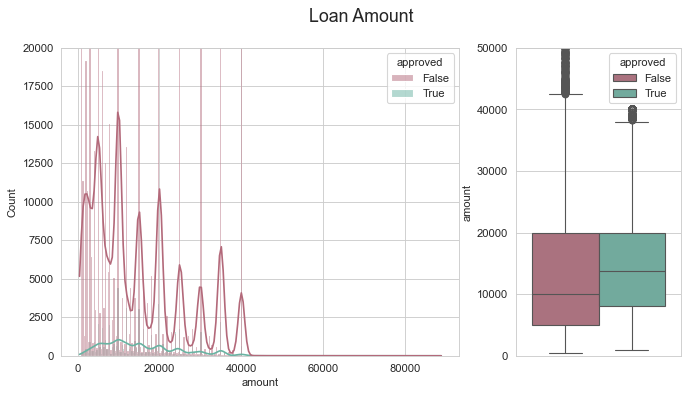

In [35]:
fig = f.plot_distribution_and_box(
    df_part_1_sample,
    "amount",
    title="Loan Amount",
    hue="approved",
    kde=True,
    palette=palette_inverted,
)
fig.axes[0].set_ylim(0, 20000)
fig.axes[1].set_ylim(0, 50000);

The plot shows that the median requested loan amount is lower than those that were approved, but the range is larger. There's some outliers in both categories, but the biggest outliers are found in the rejected loans.

&nbsp;

#### <a id='toc1_5_1_2_'></a>[Risk Score](#toc0_)

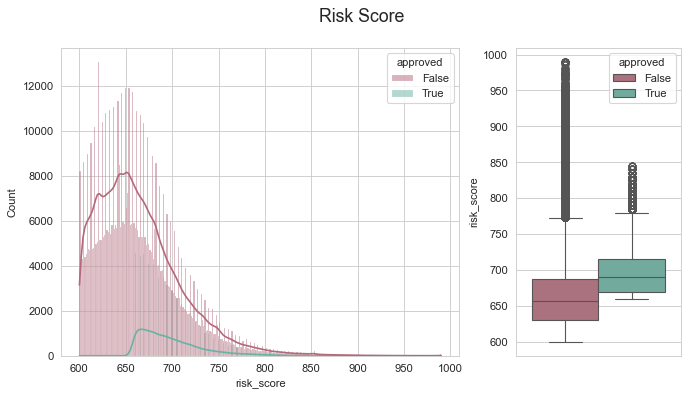

In [36]:
f.plot_distribution_and_box(
    df_part_1_sample,
    "risk_score",
    title="Risk Score",
    hue="approved",
    kde=True,
    palette=palette_inverted,
);

The plot shows that the median risk score for approved loans is about 650, which is in the typical range defined by [this article from LendingClub](https://www.lendingclub.com/resource-center/personal-finance/how-to-understand-your-credit-score). Like we just saw with the loan amount, the risk score covers a larger range in the disapproved loans than in the approved loans.

This is quite interesting. A higher risk score actually means that the risk is lower, so I was under the assumption that higher risk scores would almost guarantee approval, but the highest risk scores can actually be seen in the declined loans.

Let's see if this can be explained.

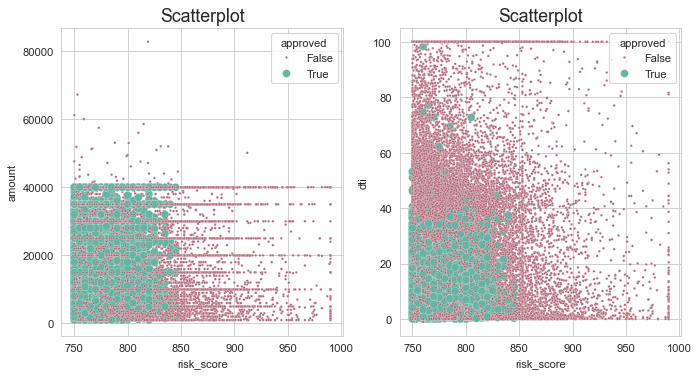

In [37]:
high_risk_score = df_part_1_sample.loc[df_part_1_sample["risk_score"] >= 750]
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
f.scatterplot(
    data=high_risk_score,
    x="risk_score",
    y="amount",
    hue="approved",
    size="approved",
    ax=ax.flatten()[0],
    sizes={True: 50, False: 5},
    palette=palette_inverted
)
f.scatterplot(
    data=high_risk_score,
    x="risk_score",
    y="dti",
    hue="approved",
    size="approved",
    ax=ax.flatten()[1],
    sizes={True: 50, False: 5},
    palette=palette_inverted,
);

This is intriguing. Risk score values above 850 seem to be declined loans regardless of loan amount and debt to income ratio.

This caused me to investigate risk/credit score a bit more, and it turns out that the maximum FICO score is 850. This introduces a lot of easy predictions for the model. Let's drop them from the dataset and continue.

In [38]:
df_part_1_sample.drop(df_part_1_sample.loc[df_part_1_sample["risk_score"] > 850].index, inplace=True)

#### <a id='toc1_5_1_3_'></a>[Debt To Income Ratio](#toc0_)

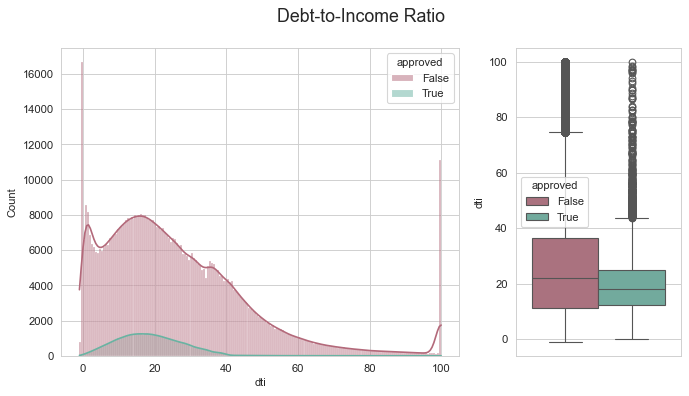

In [39]:
f.plot_distribution_and_box(
    df_part_1_sample,
    "dti",
    title="Debt-to-Income Ratio",
    hue="approved",
    kde=True,
    palette=palette_inverted,
);

I'm not sure why the dti has such a spike at 100. The range of values for accepted loans is again much lower than the range of declined loans. The median dti is higher for declined loans however, which makes sense. The more depth a person has, the less likely a new loan will be approved.

&nbsp;

#### <a id='toc1_5_1_4_'></a>[Employment Length](#toc0_)

Let's take a look at the distribution of employment length.

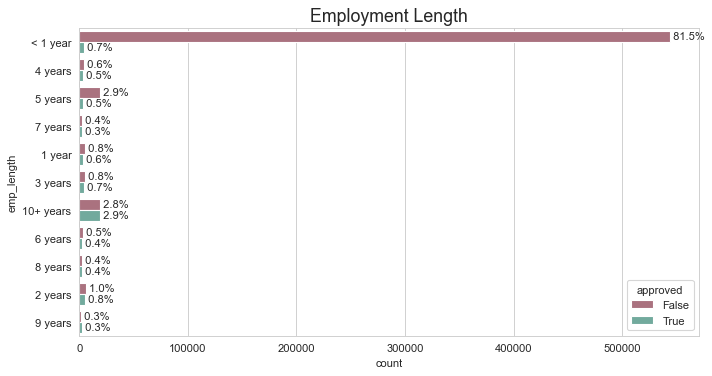

In [40]:
fig = f.countplot(
    df_part_1_sample,
    "emp_length",
    title="Employment Length",
    hue="approved",
    bar_labels=True,
    horizontal=True,
);

The majority of the dataset contains requests of people with less than 1 year of employment length. Since we're dealing with an imbalanced dataset, it might be a good idea to undersample the rows with < 1 year and 5 years of employment length to balance the dataset.

&nbsp;

#### <a id='toc1_5_1_5_'></a>[Approved](#toc0_)

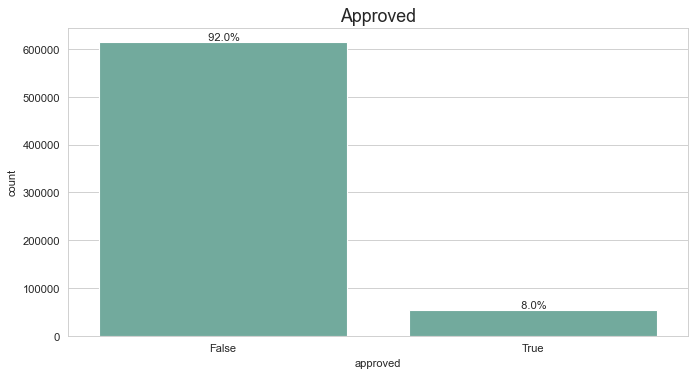

In [41]:
f.countplot(df_part_1_sample, "approved", title="Approved", bar_labels=True);

Even after dropping all those samples from the declined dataset, there's still a large class imbalance. This needs to be kept in mind in the machine learning section.

&nbsp;

### <a id='toc1_5_2_'></a>[Dataset Balancing](#toc0_)

Before creating the correlation matrix, I'm going to attempt to balance the dataset a bit better. This will all be done in a separate function that you can find at `src/lib/functions.py`, but here's a description of what it performs:

- For each employment length category that has more declined samples than approved ones, a random sample is taken from those declined to balance the approved and declined samples.

Let's call the function and inspect the data distribution after that.

<Axes: title={'center': 'Approved'}, xlabel='approved', ylabel='count'>

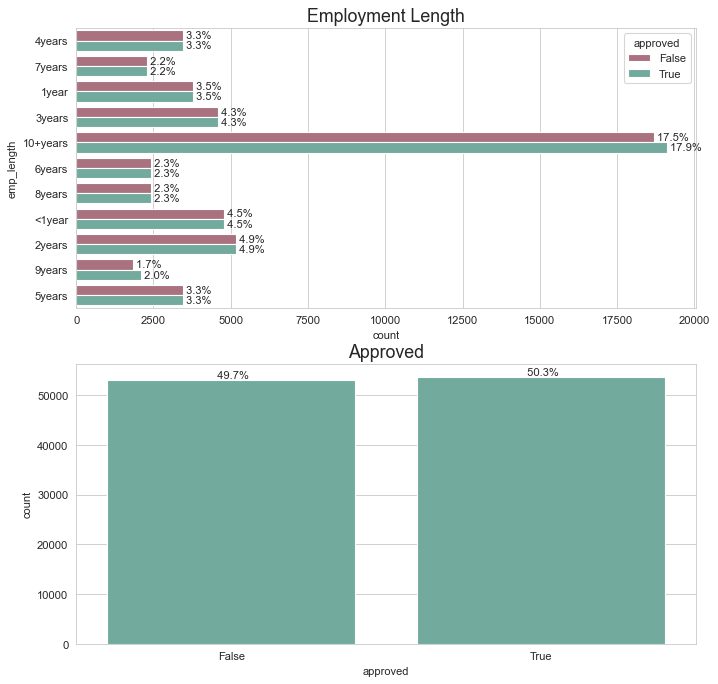

In [42]:
df_part_1_sample = f.remove_emp_length_samples(df_part_1_sample)
fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=1)


f.countplot(
    df_part_1_sample,
    "emp_length",
    title="Employment Length",
    bar_labels=True,
    horizontal=True,
    hue="approved",
    ax=ax.flatten()[0],
)


f.countplot(
    df_part_1_sample, "approved", title="Approved", bar_labels=True, ax=ax.flatten()[1]
)

That's a big improvement. Not only did this remove the unbalance in the employment length, but the dataset is much more balance in regards to application approval.

In [43]:
df_part_1_sample.head()

,amount,risk_score,dti,emp_length,approved
15,10000.0,690.0,7.12,4years,True
39,20000.0,718.0,17.39,7years,False
61,16000.0,704.0,89.43,1year,False
62,8000.0,805.0,0.22,4years,False
65,20000.0,656.0,39.33,3years,False


&nbsp;

### <a id='toc1_5_3_'></a>[Correlations](#toc0_)

Let's check out how our features correlate with each other.

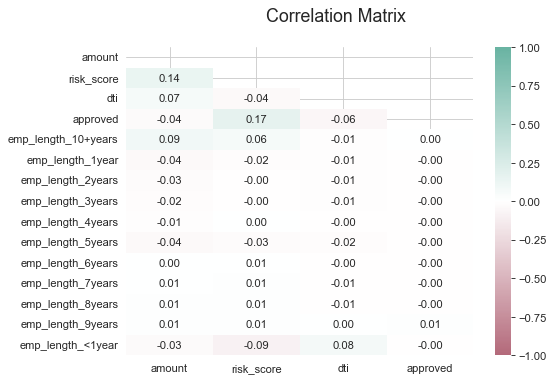

In [44]:
f.correlation_matrix(f.get_correlations(df_part_1_sample));

&nbsp;

**Thresholds**

<table style='font-size:80%;'>
<tr><td>Very strong negative correlation:</td><td> between -1.00 and -0.81</td></tr>
<tr><td>Strong negative correlation:</td><td> between -0.80 and -0.61</td></tr>
<tr><td>Moderate negative correlation:</td><td> between -0.60 and -0.31</td></tr>
<tr><td>Weak negative correlation:</td><td> between -0.30 and -0.06</td></tr>
<tr><td>No significant correlation:</td><td> between -0.05 and 0.05</td></tr>
<tr><td>Weak positive correlation:</td><td> between 0.06 and 0.30</td></tr>
<tr><td>Moderate positive correlation:</td><td> between 0.31 and 0.60</td></tr>
<tr><td>Strong positive correlation:</td><td> between 0.61 and 0.80</td></tr>
<tr><td>Very strong positive correlation:</td><td> between 0.81 and 1.00</td></tr>
</table>

&nbsp;

**Observations**

There's a weak positive correlation between the risk score and the amount requested, meaning that as risk score rises, so does the amount requested. There is also a weak positive correlation between risk score and approval of loans. This makes sense, since the higher the risk score, the greater the confidence that the borrower will repay the loan.

Other than that there is a weak negative correlation between <1 year employment length and risk score, which means that risk scores tend to be lower in borrowers that have less than 1 year of employment length, as wel as a positive dti with the same group. This positive dti means that the debt the person has compared to their income is higher for this group.

There is a final weak negative correlation that just makes the threshold, and that is dti and approval. Meaning that as debt to income ratio rises, the approval rate declines.


&nbsp;

&nbsp;

---

## <a id='toc1_6_'></a>[Statistical Analysis](#toc0_)

Let's continue with the statistical analysis part of the project.

&nbsp;

### <a id='toc1_6_1_'></a>[Hypothesis: Amount vs Debt To Income Ratio](#toc0_)

**Target Population**

Borrowers with high and low debt to income ratio.

&nbsp;

**Hypothesis**

- **Null hypothesis:** There is no statistically significant difference between the amount borrowed between high and low dti applicants

- **Alternative hypothesis:** There is a statistically significant difference between the amount borrowed between high and low dti applicants

&nbsp;

**Significance Level**

α = 0.05

&nbsp;

**Assumptions**

- The data consists of two independent groups.

&nbsp;

Let's start of by splitting the data into two populations.

In [45]:
pop_a = df_part_1_sample.loc[
    df_part_1_sample["dti"] > df_part_1_sample["dti"].median(), "amount"
]
pop_b = df_part_1_sample.loc[
    df_part_1_sample["dti"] < df_part_1_sample["dti"].median(), "amount"
]

len(pop_a), len(pop_b)

(53248, 53258)

That's quite a large sample size. Let's check whether or not they are normally distributed.

In [46]:
print(
    "Population a, data is normally distributed:"
    f" {stats.normaltest(pop_a).pvalue > 0.05} \nPopulation b, data is normally"
    f" distributed: {stats.normaltest(pop_b).pvalue > 0.05}"
)

Population a, data is normally distributed: False 
Population b, data is normally distributed: False


**Test Choice**

The data consists of two independent populations of numerical data. Both populations are not normally distributed and the sample size is relatively small. This leads me to use a Mann-Whitney U test to test the hypothesis.Test Choice

In [47]:
print(
    "Results from the Mann-Whitney U test: \nThe null hypothesis can be rejected:"
    f" {(stats.mannwhitneyu(pop_a, pop_b).pvalue < 0.05)}"
)

Results from the Mann-Whitney U test: 
The null hypothesis can be rejected: True


&nbsp;

**Observations**

The null hypothesis can be rejected, meaning that there is a statistically significant difference in the amount requested between approved and declined loans.

&nbsp;

&nbsp;

---

## <a id='toc1_7_'></a>[Machine Learning](#toc0_)

### <a id='toc1_7_1_'></a>[Data Loading](#toc0_)

Let's load the data that we'll be using as input. For this, I'm loading the entire dataset that was created before the EDA and apply the following transformations to it:

- Remove all samples with a dti ratio above 100
- Remove all samples with a risk score below 600 or above 850
- Iterate over each employment length value and remove a random sample of declined rows so that there's an equal amount of approved and declined rows. This balances the dataset across different employment lengths instead of using techniques like undersampling to get a random sample that does not deal with the imbalance in the employment length feature.

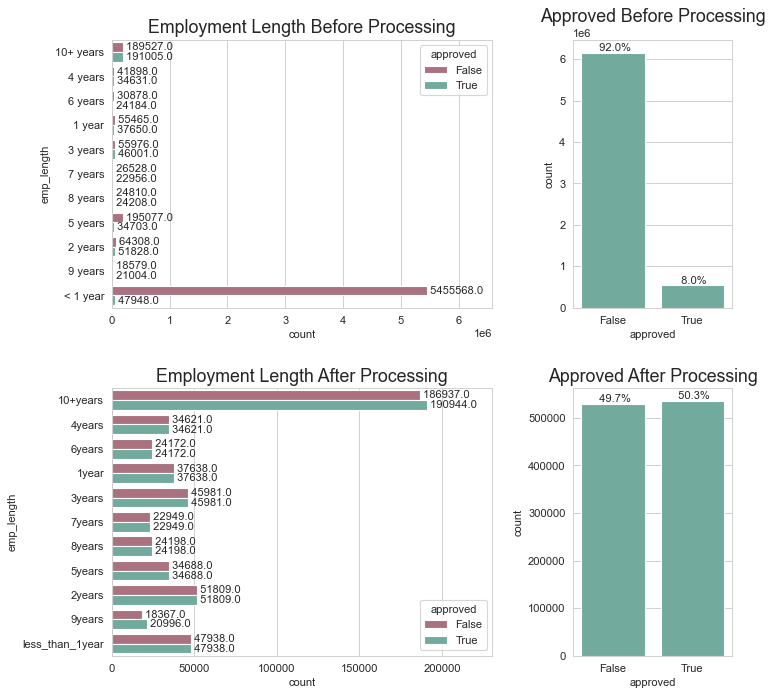

In [48]:
ml_part_1_processed = f.part_1_preprocess(df_part_1)
f.part_1_plot_processed_comparison(df_part_1, ml_part_1_processed);

&nbsp;

#### <a id='toc1_7_1_1_'></a>[Train - Test Split](#toc0_)

The final step of our data preparation is splitting the data into a training and testing set.

In [49]:
x_train, x_test, y_train, y_test = train_test_split(
    ml_part_1_processed.drop(["approved"], axis=1),
    ml_part_1_processed["approved"],
    test_size=0.30,
    random_state=42,
    stratify=ml_part_1_processed[["approved", "emp_length"]],
)
x_valid, x_test, y_valid, y_test = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42
)

logger.info(
    f"\nTraining data shape: {x_train.shape}\nValidation data shape: {x_valid.shape}\nTest"
    f" data shape: {x_test.shape}"
)

2024-02-05 11:07:16,248 - root - INFO - 
Training data shape: (745662, 4)
Validation data shape: (159785, 4)
Test data shape: (159785, 4)


Let's take a look what performance we can get out of different models.

&nbsp;

&nbsp;

---

### <a id='toc1_7_2_'></a>[Model Training and Evaluation](#toc0_)

This section contains the model training and evaluation section of the project.


#### <a id='toc1_7_2_1_'></a>[Logistic Regression](#toc0_)

Let's start of by training a logistic regression model.

In [50]:
lr_model_path = "src/models/p1_best_lr_model.joblib"
if not os.path.exists(lr_model_path):

    def lr_objective(
        trial, x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid
    ):
        lr_model = f.get_lr_model(trial)
        lr_pipeline = f.get_pipeline(
            lr_model,
            numerical_columns=["amount", "risk_score", "dti"],
            categorical_columns=["emp_length"],
        )
        lr_pipeline.fit(x_train, y_train)
        return roc_auc_score(y_valid, lr_pipeline.predict(x_valid))

    lr_study = optuna.create_study(direction="maximize")
    lr_study.optimize(lr_objective, n_trials=25)
    best_lr_model = f.get_pipeline(
        LogisticRegression(**lr_study.best_params),
        numerical_columns=["amount", "risk_score", "dti"],
        categorical_columns=["emp_length"],
    ).fit(x_train, y_train)
    joblib.dump(best_lr_model, lr_model_path)
else:
    best_lr_model = joblib.load(lr_model_path)

In [51]:
f.test_model(
    pred_train=best_lr_model.predict(x_train),
    pred_test=best_lr_model.predict(x_test),
    y_train=y_train,
    y_test=y_test,
    logger=logger,
)

2024-02-05 11:07:17,388 - root - INFO - Training scores:

2024-02-05 11:07:17,389 - root - INFO -     - Accuracy: 0.580
2024-02-05 11:07:17,390 - root - INFO -     - Precision: 0.592
2024-02-05 11:07:17,390 - root - INFO -     - Recall: 0.580
2024-02-05 11:07:17,506 - root - INFO - Test scores:

2024-02-05 11:07:17,508 - root - INFO -     - Accuracy: 0.579
2024-02-05 11:07:17,509 - root - INFO -     - Precision: 0.590
2024-02-05 11:07:17,510 - root - INFO -     - Recall: 0.579


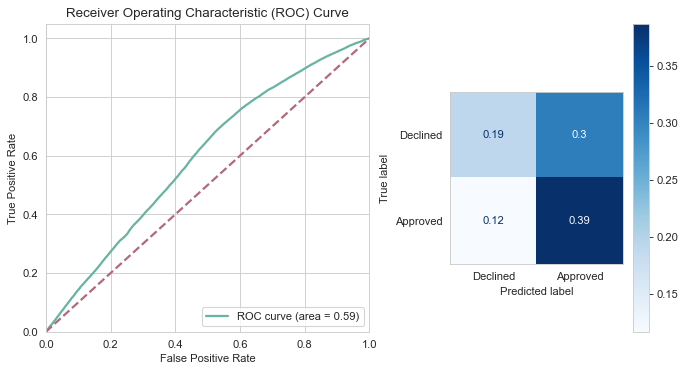

In [52]:
f.plot_roc_and_confusion_matrix(model=best_lr_model, X_test=x_test, y_test=y_test);

### <a id='toc1_7_3_'></a>[XGBoost](#toc0_)

In [53]:
xgb_model_path = "src/models/p1_best_xgb_model.joblib"
if not os.path.exists(xgb_model_path):

    def xgb_objective(
        trial, x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid
    ):
        model = f.get_xgb_model(trial, objective="binary:logistic")
        pipeline = f.get_pipeline(
            model,
            numerical_columns=["amount", "risk_score", "dti"],
            categorical_columns=["emp_length"],
        )
        pipeline.fit(x_train, y_train)
        return roc_auc_score(y_valid, pipeline.predict(x_valid))

    xgb_study = optuna.create_study(direction="maximize")
    xgb_study.optimize(xgb_objective, n_trials=50)

    best_xgb_model = f.get_pipeline(
        XGBClassifier(**xgb_study.best_params),
        numerical_columns=["amount", "risk_score", "dti"],
        categorical_columns=["emp_length"],
    ).fit(x_train, y_train)
    joblib.dump(best_xgb_model, xgb_model_path)
else:
    best_xgb_model = joblib.load(xgb_model_path)

Let's test the model's performance.

In [54]:
f.test_model(
    pred_train=best_xgb_model.predict(x_train),
    pred_test=best_xgb_model.predict(x_test),
    y_train=y_train,
    y_test=y_test,
    logger=logger,
)

2024-02-05 11:07:21,816 - root - INFO - Training scores:

2024-02-05 11:07:21,816 - root - INFO -     - Accuracy: 0.744
2024-02-05 11:07:21,816 - root - INFO -     - Precision: 0.747
2024-02-05 11:07:21,817 - root - INFO -     - Recall: 0.744
2024-02-05 11:07:21,895 - root - INFO - Test scores:

2024-02-05 11:07:21,895 - root - INFO -     - Accuracy: 0.667
2024-02-05 11:07:21,896 - root - INFO -     - Precision: 0.669
2024-02-05 11:07:21,896 - root - INFO -     - Recall: 0.667


Compared to the logistic regression model, every metric is improved by roughly 8%. Let's take a look at the roc curve.

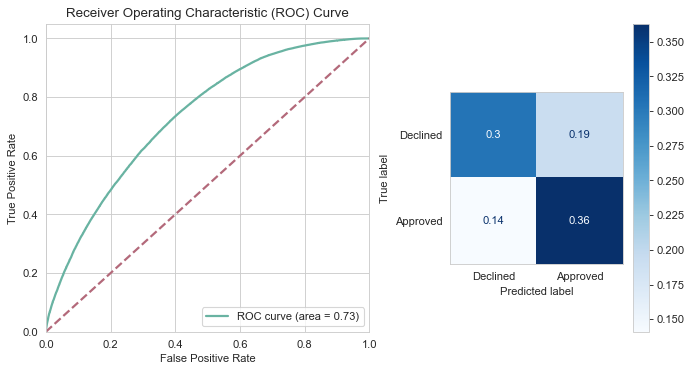

In [55]:
f.plot_roc_and_confusion_matrix(model=best_xgb_model, X_test=x_test, y_test=y_test)

This is also looking a lot better, the area under the curve is 14% larger while the values in the confusion matrix also improved.

Let's try to find the optimal threshold for optimizing the f1 score.

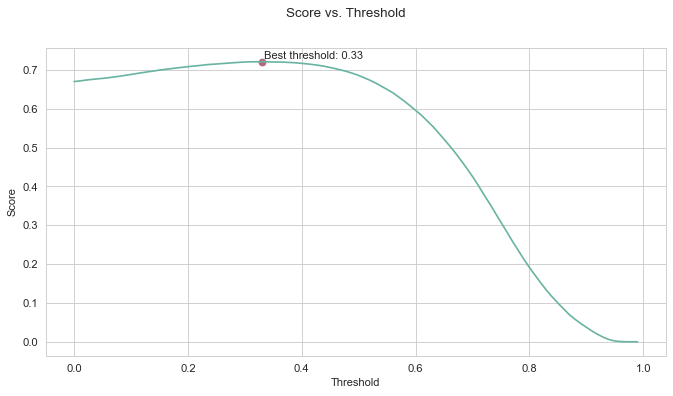

In [56]:
f.plot_threshold_score_curve(model=best_xgb_model, x_test=x_test, y_test=y_test, score_function=f1_score);

In [57]:
f.test_model(
    pred_train=f.predict_with_custom_threshold(best_xgb_model, x_train, 0.33),
    pred_test=f.predict_with_custom_threshold(best_xgb_model, x_test, 0.33),
    y_train=y_train,
    y_test=y_test,
    logger=logger,
)

2024-02-05 11:07:30,795 - root - INFO - Training scores:

2024-02-05 11:07:30,796 - root - INFO -     - Accuracy: 0.677
2024-02-05 11:07:30,796 - root - INFO -     - Precision: 0.750
2024-02-05 11:07:30,797 - root - INFO -     - Recall: 0.677
2024-02-05 11:07:30,872 - root - INFO - Test scores:

2024-02-05 11:07:30,872 - root - INFO -     - Accuracy: 0.642
2024-02-05 11:07:30,873 - root - INFO -     - Precision: 0.703
2024-02-05 11:07:30,873 - root - INFO -     - Recall: 0.642


The optimal threshold found was .33. Using this threshold caused the recall to drop by 2.5%, and improved precision by 3.4%. This should be discussed with subject matter experts to discuss if this tradeoff is worth it. It might be valuable to go back and optimize for recall instead.

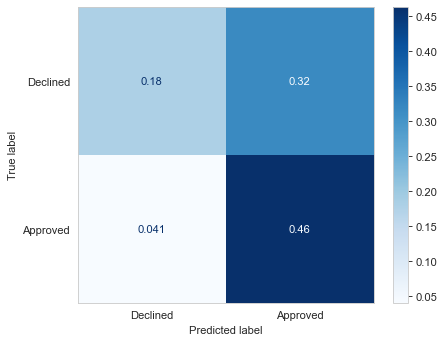

In [58]:
f.plot_confusion_matrix(
    f.predict_with_custom_threshold(best_xgb_model, x_test, 0.33),
    y_test,
    display_labels=["Declined", "Approved"],
)

The confusion matrix shows the impact of this optimization well. The loans that were wrongly declined dropped by 10%, but those wrongly approved increased by 13%. In my opinion, it might be better to to implement another metric to optimize this threshold.

Let's take a look at the most important features for the model.

In [59]:
importances = best_xgb_model.named_steps["model"].feature_importances_
feature_names = best_xgb_model.named_steps["preprocessor"].get_feature_names_out()
importances = pd.DataFrame(
    importances,
    index=feature_names,
    columns=["importance"],
).sort_values("importance", ascending=False)
importances


,importance
categorical__emp_length_less_than_1year,0.177686
numerical__risk_score,0.128809
numerical__amount,0.101275
numerical__dti,0.070645
categorical__emp_length_5years,0.065234
categorical__emp_length_10+years,0.058056
categorical__emp_length_2years,0.051732
categorical__emp_length_1year,0.051117
categorical__emp_length_3years,0.050313
categorical__emp_length_8years,0.049530


We can see that the most important features for the model are the employment length of less than a year, the risk score and the amount requested. This makes sense, a bank tries to minimize the risk of the loan not being payed back. Someone that hasn't been employed long, does not have good credit score and requests large sums of money is a bigger risk than someone with good credit score, requesting a small amount and being employed for 10 years or longer.

Let's see if the shap values confirm this.

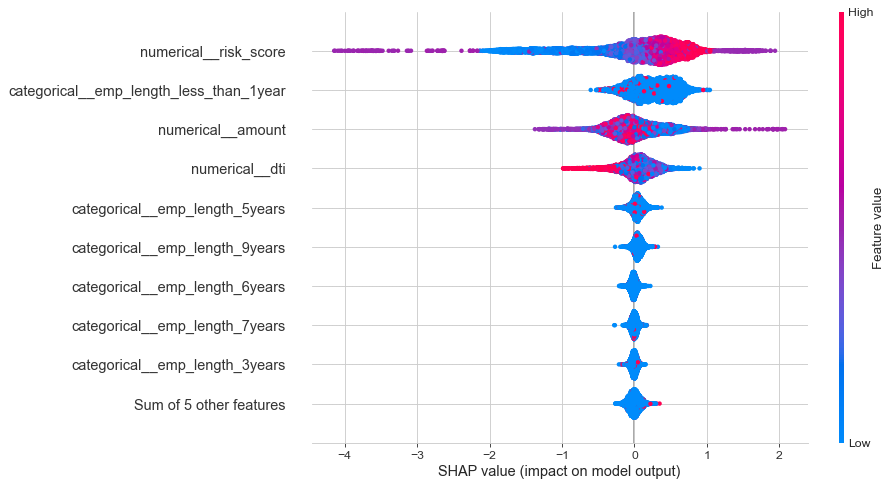

In [60]:
f.plot_xgb_shap(
    best_xgb_model.named_steps["model"],
    best_xgb_model.named_steps["preprocessor"].transform(x_test[:10_000]),
    feature_names = best_xgb_model.named_steps["preprocessor"].get_feature_names_out(),
    figsize=(10, 7),
)

The SHAP values provide us with more details on the impact of each feature. The most valuable features are still the same, but now we can see the impact on the output of the model.

Risk score has by far the biggest impact on model output, followed by the amount requested.

&nbsp;

&nbsp;

---

## <a id='toc1_8_'></a>[Summary](#toc0_)

This has been part 1 of the project. Before we move on to part 2, I'd like to provide a brief summary of what was done and found.

We started of with a dataset that was very imbalanced and filtered out a lot of rows during data cleaning for rows containing null values, values that were only present in either the approved or declined loans. The dataset was still quite imbalanced after that, with a large amount of declined applications with borrowers that had less than 1 year of employment and overall more declined loans in every other value for employment length. From these declined loans, we took a sample as large as those that were approved. This led to a much more balanced dataset and in my opinion a better dataset than if we had just taken a random sample.

On this data, statistical analysis was performed to test whether there was a statistically significant difference in amount requested between approved and declined applications.

After the dataset was balanced, and all the "easy" classifications for the model were removed, a logistic regression and XGBoost classifier were trained and tested. The XGBoost model performed the best, but should be optimized further in collaboration with subject matter experts.

Let's move on to part 2 of the project. You can find this part in the notebook named **Project Part 2.ipynb**.